# OIH Graph

Some analysis of the OIH graphs

* https://stackoverflow.com/questions/39274216/visualize-an-rdflib-graph-in-python
* https://networkx.org/documentation/stable/reference/algorithms/link_analysis.html



In [7]:
!pip install -q SPARQLWrapper
!pip -q install pydotplus
!pip -q install graphviz
!pip -q install pydotplus
!pip -q install mimesis
!pip -q install minio 
!pip -q install s3fs
!pip -q install SPARQLWrapper
!pip -q install boto3
!pip -q install 'fsspec>=0.3.3'
!pip -q install rdflib  # !pip install -q -e git+https://github.com/RDFLib/rdflib.git#egg=rdflib
!pip -q install rdflib-jsonld
!pip -q install PyLD==2.0.2
!pip -q install kglab

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graph-notebook 2.1.4 requires networkx==2.4, but you have networkx 2.5.1 which is incompatible.
aiobotocore 1.3.3 requires botocore<1.20.107,>=1.20.106, but you have botocore 1.21.10 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graph-notebook 2.1.4 requires networkx==2.4, but you have networkx 2.5.1 which is incompatible.
boto3 1.18.4 requires botocore<1.22.0,>=1.21.4, but you have botocore 1.20.106 which is incompatible.


In [22]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import dask, boto3
import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
import kglab

In [23]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

## Some inspection queries for OIH Graph

In [26]:
oihgraph = "https://graph.collaborium.io/blazegraph/namespace/oihdev/sparql"

In [27]:
rp3 = """
prefix prov: <http://www.w3.org/ns/prov#>
PREFIX con: <http://www.ontotext.com/connectors/lucene#>
PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/>
PREFIX schemaold: <http://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
WHERE
{

   ?lit bds:search "coral" .
   ?lit bds:matchAllTerms "false" .
   ?lit bds:relevance ?score .
   ?s ?p ?lit .

   graph ?g {
    ?s ?p ?lit .
    ?s rdf:type ?type . 
    OPTIONAL { ?s schema:name ?name .   }
    OPTIONAL { ?s schema:headline ?headline .   }
    OPTIONAL { ?s schema:url ?url .   }
    OPTIONAL { ?s schema:description ?description .    }
  }
   ?sp prov:generated ?g  .
   ?sp prov:used ?used .
   ?used prov:hadMember ?hm .
   ?hm prov:wasAttributedTo ?wat .
   ?wat rdf:name ?orgname .
   ?wat rdfs:seeAlso ?domain


}
ORDER BY DESC(?score)
LIMIT 30
OFFSET 0 
"""

dfrp3 = get_sparql_dataframe(oihgraph, rp3)
dfrp3.head(10)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner:milled:obis:13392d707024cdd4e509d6...,t12576,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/b91d89db-79d6-4bd3-84...,coral,The purpose of the Coral Reef Evaluation and M...,None
1,urn:gleaner:milled:obis:18d1180a74c200d06f9114...,t13860,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/46005357-02b8-4f17-b0...,coral,The purpose of the Coral Reef Evaluation and M...,None
2,urn:gleaner:milled:obis:24bac898cda34444176ec4...,t16445,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/d4ec17b8-fc96-49b9-b7...,coral,The purpose of the Coral Reef Evaluation and M...,None
3,urn:gleaner:milled:obis:24d453e3a4ea6d1f117e5c...,t16471,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/36bca81c-6d77-4fd4-a9...,coral,The purpose of the Coral Reef Evaluation and M...,None
4,urn:gleaner:milled:obis:2524f94920efb8f87029bf...,t16581,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Interacciones entre Corales y CÃ©spedes algale...,https://obis.org/dataset/e39be6ef-3c91-4e97-ba...,coral,Para el componente denominado âInteracciÃ³n ...,None
5,urn:gleaner:milled:obis:2bf98aa888d856b8706176...,t18254,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/431f96f7-521c-4182-ae...,coral,The purpose of the Coral Reef Evaluation and M...,None
6,urn:gleaner:milled:obis:2d67f3625478df2c1520ae...,t18644,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/d88a91c1-2685-4afa-9a...,coral,The purpose of the Coral Reef Evaluation and M...,None
7,urn:gleaner:milled:obis:30c1e35e0d4a09e3aafd38...,t19399,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/b856037f-bbdf-45da-9b...,coral,The purpose of the Coral Reef Evaluation and M...,None
8,urn:gleaner:milled:obis:384060928d22941acabcb6...,t21027,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Nematoda from Kenya and Zanzibar,https://obis.org/dataset/aa9787d6-c4db-4fde-8e...,Coral,Data on the species and trophic composition of...,None
9,urn:gleaner:milled:obis:3c03fa0cea67f703cdf249...,t21600,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/c170a0a3-c669-436b-a1...,coral,The purpose of the Coral Reef Evaluation and M...,None


In [29]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
import networkx as nx
import matplotlib.pyplot as plt
import gzip

with gzip.open('./data/oceanexperts_graph.nq.gz', 'rb') as f:
    file_content = f.read()

g = rdflib.Graph()
g.parse(data = file_content, format="nquads")

G = rdflib_to_networkx_digraph(g)
# G = rdflib_to_networkx_multidigraph(result)

# # Plot Networkx instance of RDF Graph
# pos = nx.spring_layout(G, scale=2)
# edge_labels = nx.get_edge_attributes(G, 'r')b
# #nx.draw_networkx_edge_labels(G, pos, labels=edge_labels)
# nx.draw_networkx_edge_labels(G, pos)
# nx.draw(G, with_labels=True)

In [30]:
pr = nx.pagerank(G,alpha=0.9)
# for key, value in pr.items():
#     print(key, ' : ', value)

In [32]:
import pandas as pd
prdf = pd.DataFrame.from_dict(pr, orient='index')

In [33]:
prdf.dtypes

0    float64
dtype: object

In [34]:
prdf.sort_values(by=0,ascending=False, inplace=True,)
prdf.head(20)

,0
https://schema.org/Place,0.058482
https://schema.org/CourseInstance,0.018446
https://schema.org/Course,0.016571
UNESCO/IOC Project Office for IODE Wandelaarkaai 7 - Pakhuis 61 B-8400 Oostende Belgium,0.007863
Russia,0.007497
UNESCO/IOC Project Office for IODE Wandelaarkaai 7 8400 Oostende Belgium,0.006203
Wandelaarkaai 7 8400 Oostende Belgium,0.003761
Belgium,0.002931
RV Professor Logachev Russia,0.002624
UNESCO / IOC Project Office for IODE Wandelaarkaai 7 8400 Oostende Belgium,0.002360


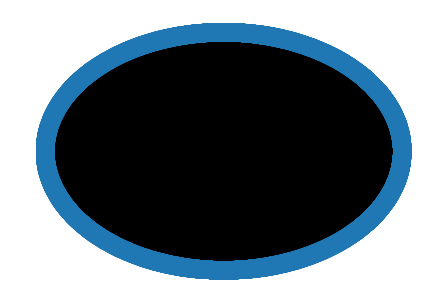

In [35]:
nx.draw_circular(G, with_labels = False)
plt.show() # display

(array([3.499e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  86.5, 172. , 257.5, 343. , 428.5, 514. , 599.5, 685. ,
        770.5, 856. ]),
 <BarContainer object of 10 artists>)

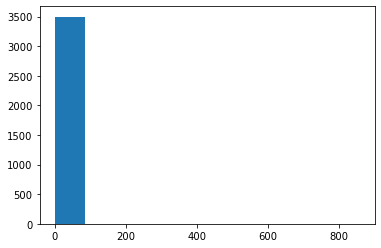

In [36]:
plt.hist([v for k,v in nx.degree(G)])

(array([2200.,    0.,    0.,    0.,    0.,  858.,    0.,   20.,    0.,
         424.]),
 array([0.00000000e+00, 3.26437344e-08, 6.52874689e-08, 9.79312033e-08,
        1.30574938e-07, 1.63218672e-07, 1.95862407e-07, 2.28506141e-07,
        2.61149876e-07, 2.93793610e-07, 3.26437344e-07]),
 <BarContainer object of 10 artists>)

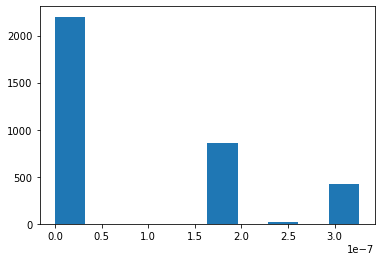

In [37]:
plt.hist(nx.centrality.betweenness_centrality(G).values())